In [1]:
library("lme4")
library("ggplot2")
library("dplyr")
library(MASS)
library("BayesFactor")
library("car")
library("scales")
library("lmerTest")
#library("MuMIn")
library("plyr")
library("knitr")
library("MASS")
library("corrplot")
library("RColorBrewer")
library("rstatix")
library("ggpubr")
#library("rgr")
library("lattice")
library("correlation")
library("cowplot")

Loading required package: Matrix


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.4. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functi

In [2]:
##Source for "SummarySE": http://www.cookbook-r.com/Manipulating_data/Summarizing_data/
##
##
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [3]:
DataPath <-'../Inputs/Humans_Part_II/R_Data/HumanData.txt'
mydata <- read.delim(DataPath, sep="\t", header=T, stringsAsFactors=F)
nb_rows<-nrow(mydata)
nb_rows
head(mydata,10)

[1] 6150

,name,Strategy,Measure,GameNb,Value
,<chr>,<chr>,<chr>,<int>,<dbl>
1,A122LRCSBAD6DC,streamed,Deflations,1,39
2,A122LRCSBAD6DC,streamed,Deflations,2,20
3,A122LRCSBAD6DC,streamed,Deflations,3,25
4,A122LRCSBAD6DC,streamed,Deflations,4,23
5,A122LRCSBAD6DC,streamed,Deflations,5,26
6,A122LRCSBAD6DC,streamed,Deflations,6,30
7,A122LRCSBAD6DC,streamed,Deflations,7,27
8,A122LRCSBAD6DC,streamed,Deflations,8,37
9,A122LRCSBAD6DC,streamed,Deflations,9,16


# Averaging data from last 3 games

In [4]:
#1) Filtering irrelevant data
lastdata <- mydata %>% filter((GameNb==13 | GameNb==14 | GameNb==15))
head(lastdata,10)

,name,Strategy,Measure,GameNb,Value
,<chr>,<chr>,<chr>,<int>,<dbl>
1,A122LRCSBAD6DC,streamed,Deflations,13,8.0000000
2,A122LRCSBAD6DC,streamed,Deflations,14,16.0000000
3,A122LRCSBAD6DC,streamed,Deflations,15,12.0000000
4,A122LRCSBAD6DC,streamed,Misses,13,14.0000000
5,A122LRCSBAD6DC,streamed,Misses,14,37.0000000
6,A122LRCSBAD6DC,streamed,Misses,15,24.0000000
7,A122LRCSBAD6DC,streamed,Resets,13,2.0000000
8,A122LRCSBAD6DC,streamed,Resets,14,15.0000000
9,A122LRCSBAD6DC,streamed,Resets,15,8.0000000


In [5]:
#2) average across game numbers
avgdata <- lastdata %>% group_by(name,Strategy,Measure) %>% dplyr::summarize(Value = mean(Value))
head(avgdata,10)

`summarise()` has grouped output by 'name', 'Strategy'. You can override using the `.groups` argument.


name,Strategy,Measure,Value
<chr>,<chr>,<chr>,<dbl>
A11LNK1U3DT08V,coupled,Deflations,18.3333333
A11LNK1U3DT08V,coupled,Entropy,2.5116635
A11LNK1U3DT08V,coupled,LogCV,-1.5092415
A11LNK1U3DT08V,coupled,Misses,26.0000000
A11LNK1U3DT08V,coupled,Resets,3.0000000
A11LNK1U3DT08V,coupled,Right_Periodicity,496.0000000
A11LNK1U3DT08V,coupled,Right_Regularity,0.4003696
A11LNK1U3DT08V,coupled,Score,1850.0000000
A11LNK1U3DT08V,coupled,Shot_Periodicity,485.3333333


In [6]:
AllMeasures <- as.factor(avgdata$Measure)
Measure_Levels <- levels(AllMeasures)
Measure_Levels
avgdata$Strategy <- ordered(avgdata$Strategy, levels = c("streamed", "coupled"))
write.table(avgdata,"Humans_T_test_data.txt",sep="\t",row.names=FALSE)

[1] "Deflations"        "Entropy"           "LogCV"            
 [4] "Misses"            "Resets"            "Right_Periodicity"
 [7] "Right_Regularity"  "Score"             "Shot_Periodicity" 
[10] "Shot_Regularity"

In [7]:
#avgdata <- lastdata %>% group_by(name,Strategy,Measure) %>% dplyr::summarize(Value = mean(Value))
head(avgdata,10)

name,Strategy,Measure,Value
<chr>,<ord>,<chr>,<dbl>
A11LNK1U3DT08V,coupled,Deflations,18.3333333
A11LNK1U3DT08V,coupled,Entropy,2.5116635
A11LNK1U3DT08V,coupled,LogCV,-1.5092415
A11LNK1U3DT08V,coupled,Misses,26.0000000
A11LNK1U3DT08V,coupled,Resets,3.0000000
A11LNK1U3DT08V,coupled,Right_Periodicity,496.0000000
A11LNK1U3DT08V,coupled,Right_Regularity,0.4003696
A11LNK1U3DT08V,coupled,Score,1850.0000000
A11LNK1U3DT08V,coupled,Shot_Periodicity,485.3333333



	Welch Two Sample t-test

data:  Value by Strategy
t = -12.155, df = 12.095, p-value = 3.859e-08
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -152.9978 -106.5207
sample estimates:
mean in group streamed  mean in group coupled 
              356.7407               486.5000 



Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


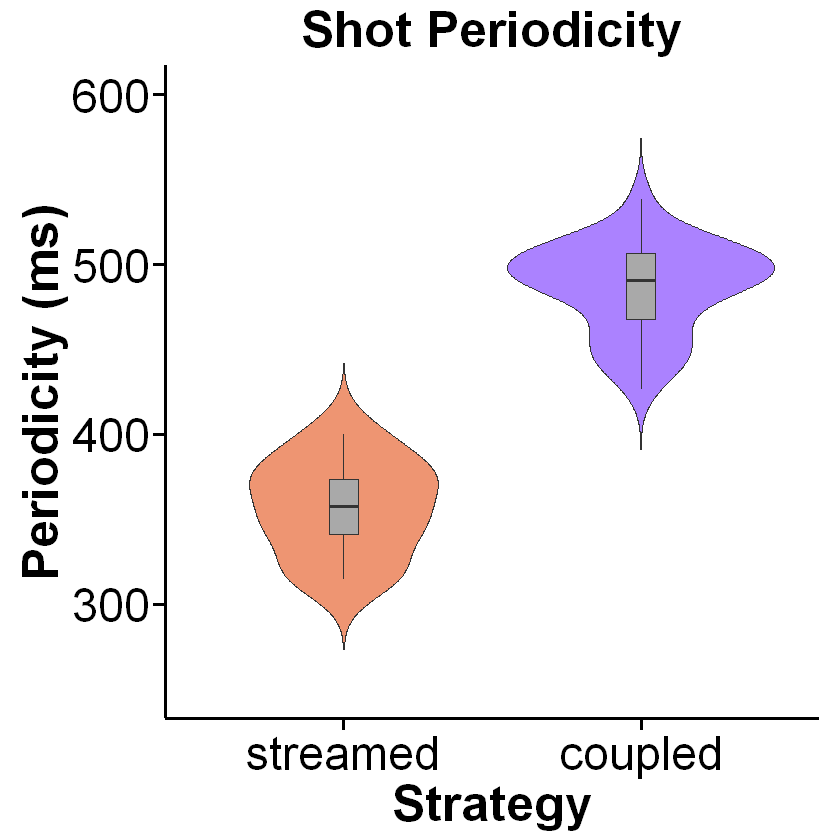

In [8]:
#3) Violin plot to compare fast & slow groups

#Shot_Periodicity
PerData <- avgdata %>% filter(Measure=='Shot_Periodicity')
m1<-t.test(Value ~ Strategy, data=PerData)
print(m1)

dp1<-ggplot(PerData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Shot Periodicity",x="Strategy", y = "Periodicity (ms)")+
  geom_boxplot(width=0.1,fill="darkgray")
dp1 <- dp1+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) + #"violetred1","royalblue" #"white","gray45"
  theme_classic() +
  scale_y_continuous(limits=c(250, 600)) +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp1
ggsave("./Figures_Humans/Shot_periodicity.png",plot=dp1,width=12,height=8)


	Welch Two Sample t-test

data:  Value by Strategy
t = -5.2871, df = 38.173, p-value = 5.334e-06
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -21.665996  -9.669652
sample estimates:
mean in group streamed  mean in group coupled 
              15.92593               31.59375 



Warning message:
"Unknown or uninitialised column: `Deflations`."
Warning message in min(thisData$Deflations):
"no non-missing arguments to min; returning Inf"


[1] Inf


Warning message:
"Removed 60 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 60 rows containing missing values (`geom_violin()`)."


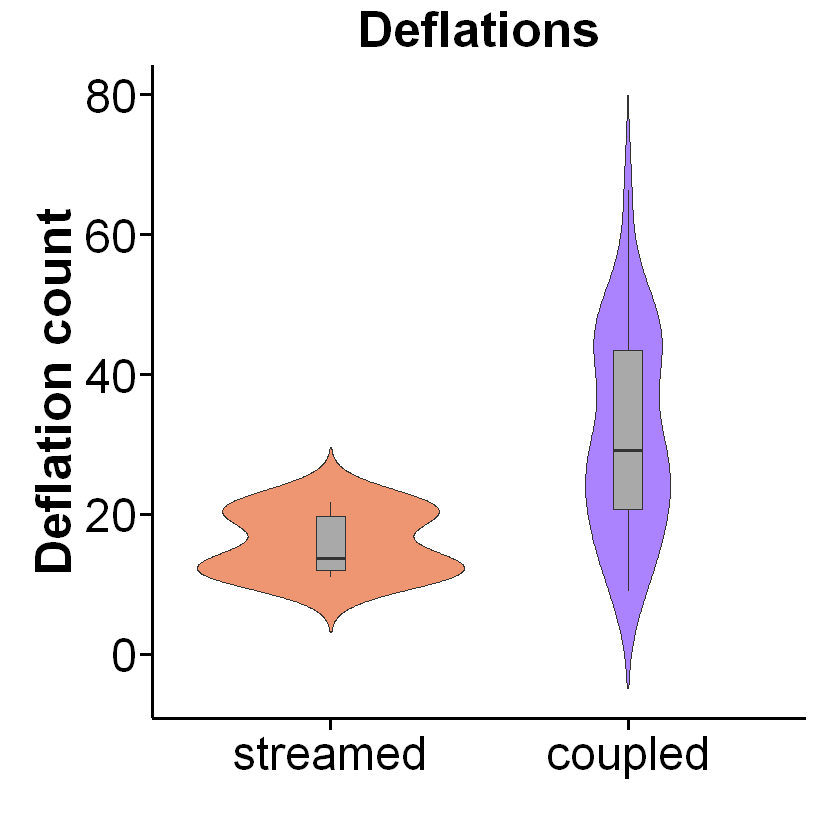

In [9]:
#Deflations
thisData <- avgdata %>% filter(Measure=='Deflations')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)
print(min(thisData$Deflations))

dp2<-ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Deflations",x="", y = "Deflation count")+
  geom_boxplot(width=0.1,fill="darkgray")
dp2 <- dp2+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  scale_y_continuous(limits=c(-5, 80)) +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp2
ggsave("./Figures_Humans/Deflations.png",plot=dp2,width=12,height=8)


	Welch Two Sample t-test

data:  Value by Strategy
t = 1.6457, df = 22.143, p-value = 0.1139
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -0.8305392  7.2263726
sample estimates:
mean in group streamed  mean in group coupled 
              8.333333               5.135417 



Warning message:
"Removed 1 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_violin()`)."


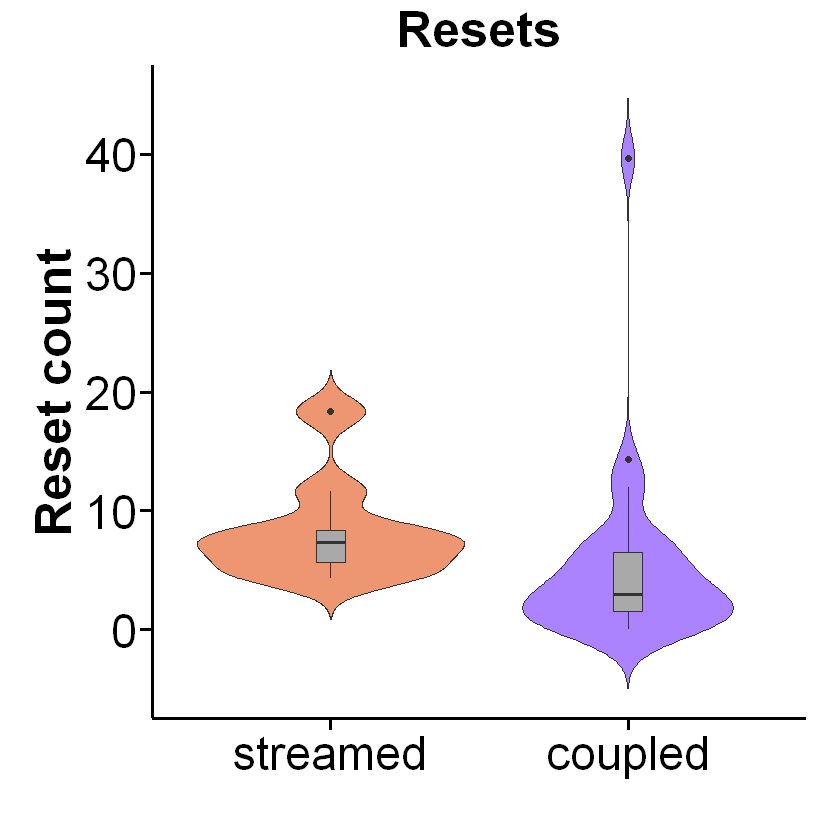

In [10]:
#Resets
thisData <- avgdata %>% filter(Measure=='Resets')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)

dp3 <- ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Resets",x="", y = "Reset count")+
  geom_boxplot(width=0.1,fill="darkgray")
dp3 <- dp3+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  scale_y_continuous(limits=c(-5, 45)) +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp3
ggsave("./Figures_Humans/Resets.png",plot=dp3,width=12,height=8)


	Welch Two Sample t-test

data:  Value by Strategy
t = -0.79904, df = 31.662, p-value = 0.4302
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -18.20351   7.94888
sample estimates:
mean in group streamed  mean in group coupled 
              36.51852               41.64583 



Warning message:
"Removed 77 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 77 rows containing missing values (`geom_violin()`)."


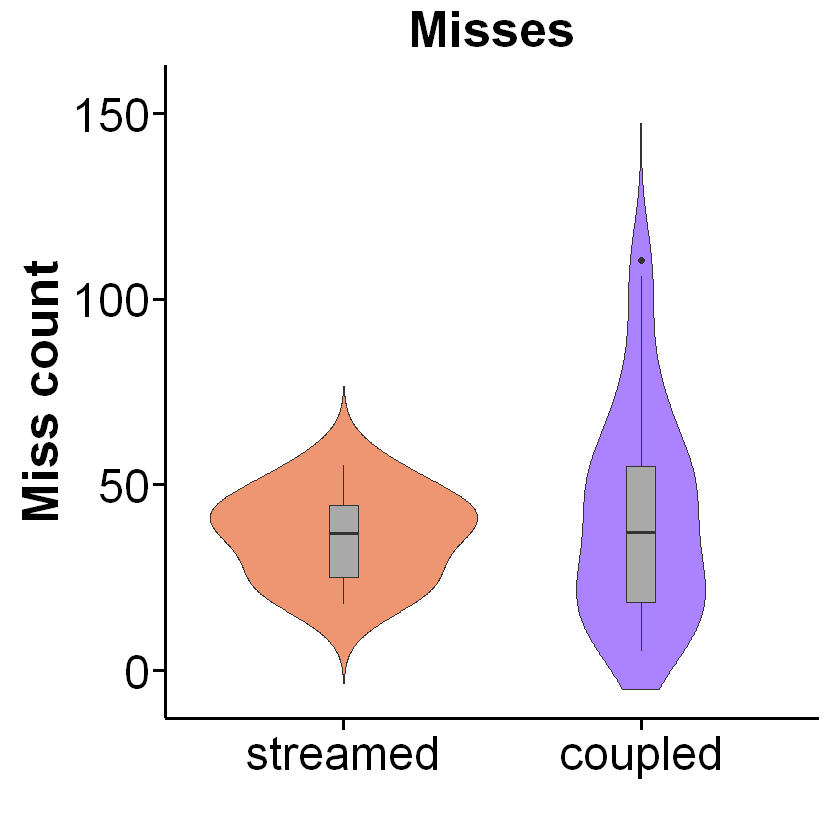

In [11]:
#Misses
thisData <- avgdata %>% filter(Measure=='Misses')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)

dp4<-ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Misses",x="", y = "Miss count")+
  geom_boxplot(width=0.1,fill="darkgray")
dp4 <- dp4+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  scale_y_continuous(limits=c(-5, 155)) +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp4
ggsave("./Figures_Humans/Misses.png",plot=dp4,width=12,height=8)


	Welch Two Sample t-test

data:  Value by Strategy
t = -0.11036, df = 38.878, p-value = 0.9127
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -0.1465669  0.1314017
sample estimates:
mean in group streamed  mean in group coupled 
              2.754407               2.761989 



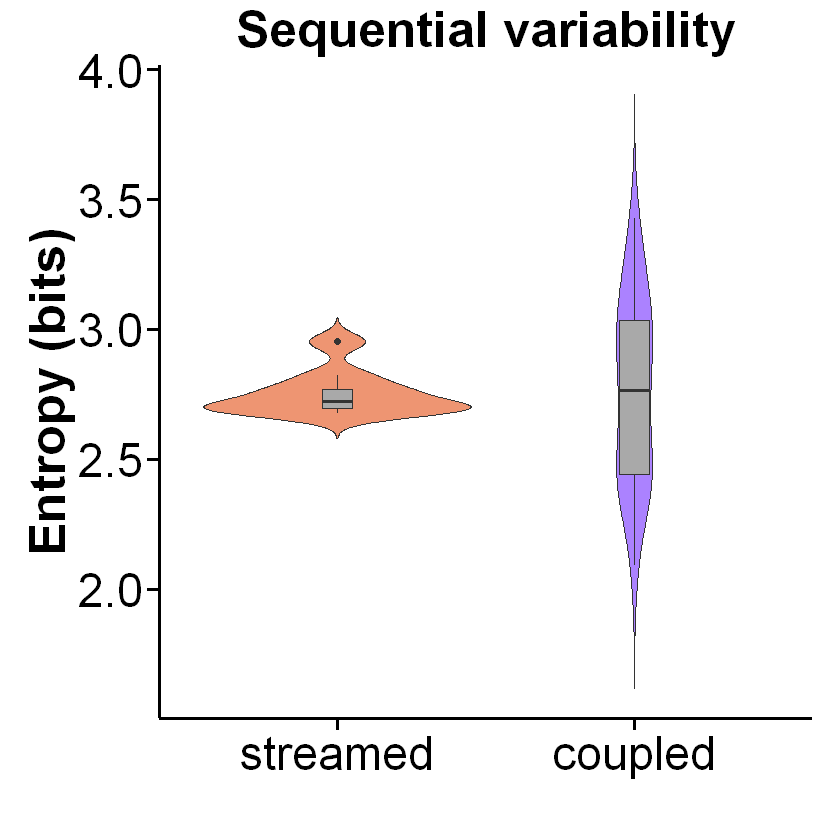

In [12]:
#Entropy
thisData <- avgdata %>% filter(Measure=='Entropy')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)

dp5<-ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Sequential variability",x="", y = "Entropy (bits)")+
  geom_boxplot(width=0.1,fill="darkgray")
dp5 <- dp5+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp5
ggsave("./Figures_Humans/Entropy.png",plot=dp5,width=12,height=8)


	Welch Two Sample t-test

data:  Value by Strategy
t = -2.3906, df = 37.248, p-value = 0.02199
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -0.24251093 -0.02003772
sample estimates:
mean in group streamed  mean in group coupled 
             -1.358421              -1.227146 



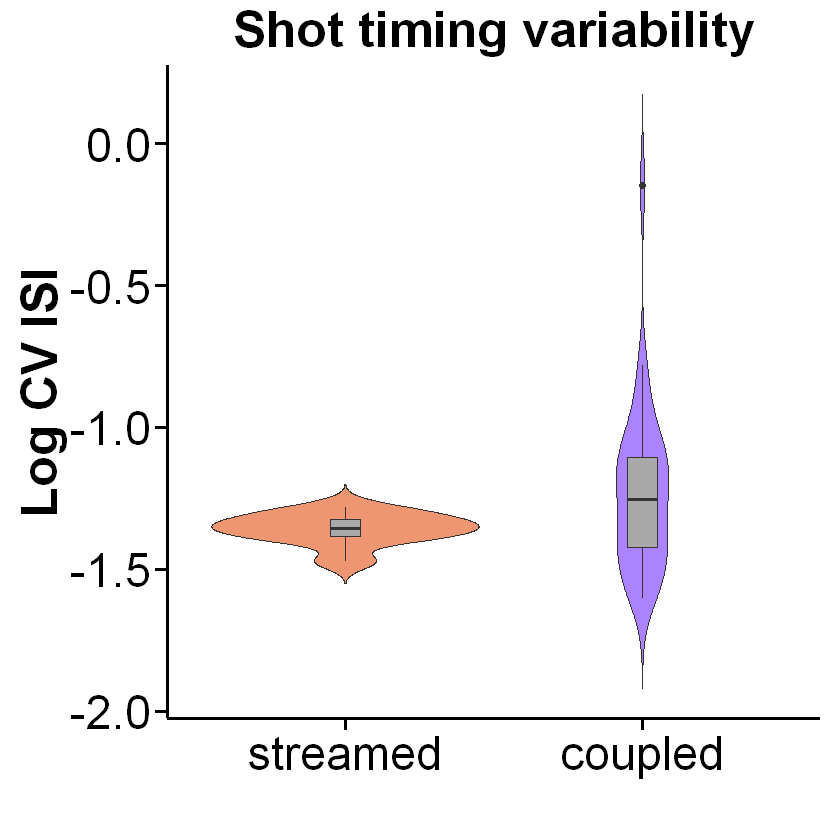

In [13]:
#LogCV
thisData <- avgdata %>% filter(Measure=='LogCV')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)

dp6<-ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Shot timing variability",x="", y = "Log CV ISI")+
  geom_boxplot(width=0.1,fill="darkgray")
dp6 <- dp6+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp6
ggsave("./Figures_Humans/LogCV.png",plot=dp6,width=12,height=8)

In [14]:
#Score
thisData <- avgdata %>% filter(Measure=='Score')
StreamPerf <- thisData %>% filter(Strategy=='streamed')
coupledPerf <- thisData %>% filter(Strategy=='coupled')

StreamData <- StreamPerf %>% filter(Measure=='Score')
CoupledData <- coupledPerf %>% filter(Measure=='Score')
mu1<-mean(StreamData$Value)
mu1
mu2 <- mean(CoupledData$Value)
mu2
sd1<-sd(StreamData$Value)
sd1
sd2<-sd(CoupledData$Value)
sd2
StreamData

[1] 2430.296

[1] 1308.646

[1] 279.9818

[1] 560.4358

name,Strategy,Measure,Value
<chr>,<ord>,<chr>,<dbl>
A122LRCSBAD6DC,streamed,Score,2517.333
A13G6IRFQBEE8K,streamed,Score,2497.333
A19X8IA9EKC3XH,streamed,Score,2886.667
A1RH69F7I73LRW,streamed,Score,2285.333
A1SISJL5ST2PWH,streamed,Score,2629.333
A1U2A42K8FV3RA,streamed,Score,1930.000
AAE1COF4E8740,streamed,Score,2611.333
ACGHHDT7RY1AH,streamed,Score,2299.333
AFM65NU0UXIGP,streamed,Score,2216.000



	Welch Two Sample t-test

data:  Value by Strategy
t = 8.2409, df = 27.257, p-value = 7.033e-09
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
  842.5042 1400.7967
sample estimates:
mean in group streamed  mean in group coupled 
              2430.296               1308.646 



Warning message:
"Removed 56 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 56 rows containing missing values (`geom_violin()`)."


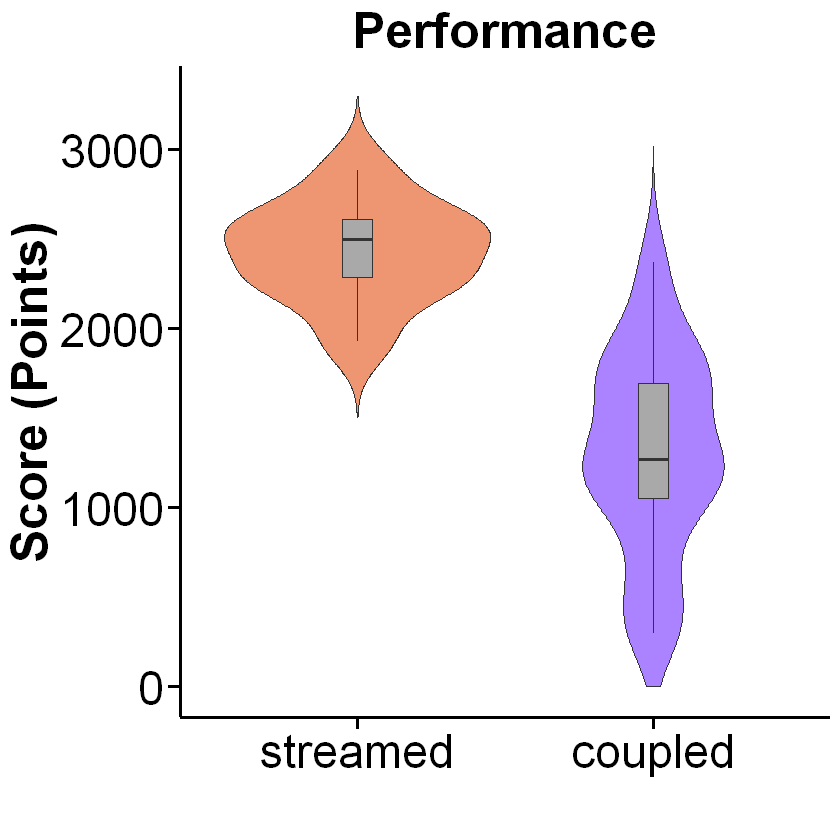

In [15]:
#Score
thisData <- avgdata %>% filter(Measure=='Score')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)

dp7<-ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Performance",x="", y = "Score (Points)")+
  geom_boxplot(width=0.1,fill="darkgray")
dp7 <- dp7+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  scale_y_continuous(limits=c(-5, 3300)) +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp7
ggsave("./Figures_Humans/Score.png",plot=dp7,width=12,height=8)


	Welch Two Sample t-test

data:  Value by Strategy
t = -9.3246, df = 38.999, p-value = 1.785e-11
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -0.2982762 -0.1919391
sample estimates:
mean in group streamed  mean in group coupled 
             0.1156653              0.3607730 



Warning message:
"Removed 24 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 24 rows containing missing values (`geom_violin()`)."


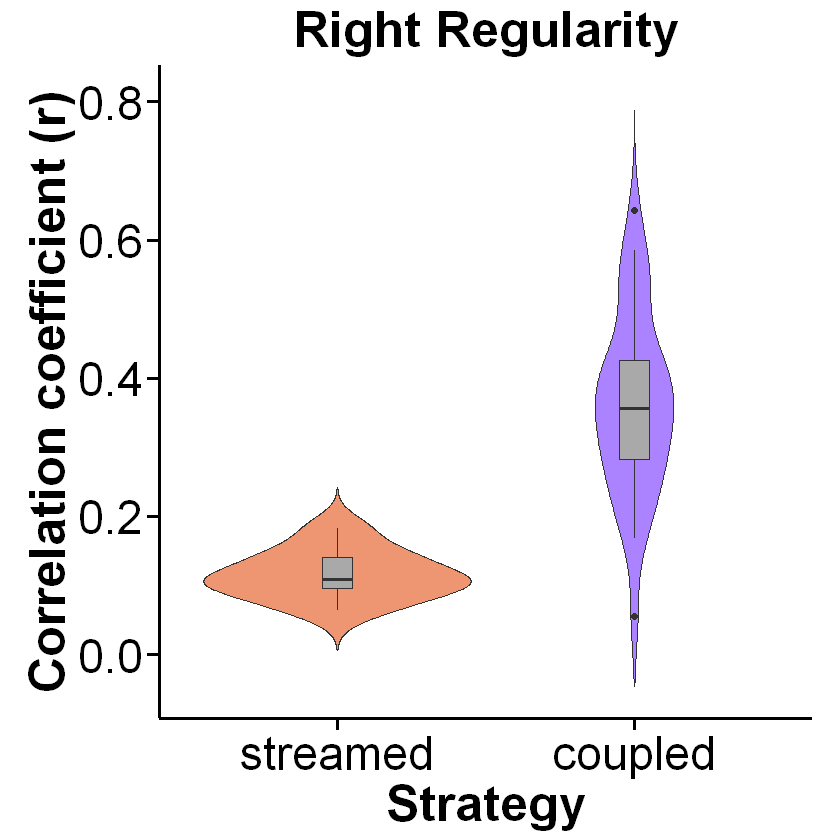

In [16]:
#Right Regularity
thisData <- avgdata %>% filter(Measure=='Right_Regularity')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)

dp8<-ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Right Regularity",x="Strategy", y = "Correlation coefficient (r)")+
  geom_boxplot(width=0.1,fill="darkgray")
dp8 <- dp8+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  scale_y_continuous(limits=c(-0.05, 0.81)) +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp8
ggsave("./Figures_Humans/RightRegularity.png",plot=dp8,width=12,height=8)


	Welch Two Sample t-test

data:  Value by Strategy
t = -0.48528, df = 12.904, p-value = 0.6356
alternative hypothesis: true difference in means between group streamed and group coupled is not equal to 0
95 percent confidence interval:
 -0.11935599  0.07559727
sample estimates:
mean in group streamed  mean in group coupled 
             0.3687086              0.3905880 



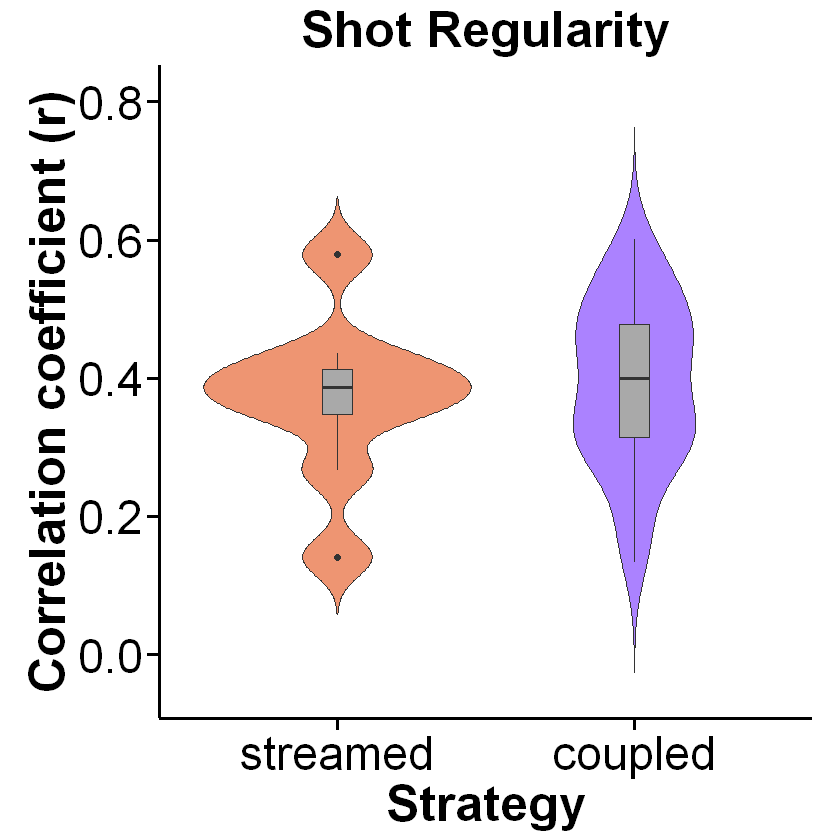

In [17]:
#Shot Regularity
thisData <- avgdata %>% filter(Measure=='Shot_Regularity')
mx<-t.test(Value ~ Strategy, data=thisData)
print(mx)

dp9<-ggplot(thisData, aes(x=Strategy, y=Value,fill=Strategy)) + 
  geom_violin(trim=FALSE)+
  labs(title="Shot Regularity",x="Strategy", y = "Correlation coefficient (r)")+
  geom_boxplot(width=0.1,fill="darkgray")
dp9 <- dp9+scale_fill_manual(values=c("lightsalmon2","mediumpurple1")) +
  theme_classic() +
  scale_y_continuous(limits=c(-0.05, 0.81)) +
  theme(plot.title = element_text(size=30,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 28,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 24,face = "bold",color='black'),
           axis.title = element_text( size = 30, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text(size=18),
           legend.title = element_text(size=20),
           legend.position="none",
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1)
dp9
ggsave("./Figures_Humans/ShotRegularity.png",plot=dp9,width=12,height=8)

In [18]:
# simple grid
gg3 <- plot_grid(dp7,dp5,dp6,dp3,dp2,dp4,dp1,dp9,dp8,nrow=3)
ggsave("./Figures_Humans/Multi_violin_plots.png",gg3,width=22,height=18)

Warning message:
"Removed 56 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 60 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 77 rows containing missing values (`geom_violin()`)."
Warning message:
"Removed 24 rows containing missing values (`geom_violin()`)."
